In [2]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

from utils import update_paid_days, update_paid_days_historical, google_plot
from python_ml_common.loader import RedshiftLoader

Instantiate env vars if not already set in jupyter startup commands, which can be done by adding following to settings.json:

```
"jupyter.runStartupCommands": [
    "%load_ext autoreload",
    "%autoreload 2",
    "from python_ml_common.config import load_envvars",
    "load_envvars()",
    "import os",
    "os.environ['PATH'] += ':/opt/homebrew/bin'", //Fix weirdness on local
  ]
```

In [3]:
from python_ml_common.config import load_envvars
load_envvars()

In [5]:
rs = RedshiftLoader()

### (0) Data

In [41]:
with open('google_actual_ltv_12_60.sql', 'r') as f:
    sql = f.read()
    signup_value = rs.load(sql)

In [42]:
signup_value.signup_month = pd.to_datetime(signup_value.signup_month)
signup_value['projected_paid_days'] = signup_value['projected_paid_days'].astype('float64')
signup_value = signup_value.loc[signup_value.signup_month <'2024-09-01'].reset_index(drop=True)

In [9]:
signup_value.head()

,channels,signup_month,increments_from_signup,signups,paid_days,trips,net_revenue,pcp,pcp_modified_with_halo,ds_curve,avg_historical_curve,projected_paid_days,net_revenue_per_day,projected_net_revenue_per_day,cost_per_trip_day,avg_paid_halo,projected_cost_per_day
0,Google_Desktop,2017-09-01,31,2235,12.0,3.200000,465.080000,344.456365,418.943457,NaN,1.022439,12.0,38.756667,38.756667,20.341363,1.250,10.051970
1,Google_Desktop,2017-09-01,49,2235,92.0,25.167949,3542.609103,2696.953811,3282.627036,NaN,0.976622,92.0,38.506621,38.506621,20.341363,1.250,9.191905
2,Google_Mobile,2017-09-01,10,5533,200.0,39.264210,4053.336285,-3374.449007,-6219.928319,NaN,0.997089,200.0,20.266681,20.266681,20.828945,1.800,37.138926
3,Google_Mobile,2017-09-01,18,5533,143.0,31.095616,3009.317447,-14781.343445,-26714.753629,NaN,1.065196,143.0,21.044178,21.044178,20.828945,1.800,124.410216
4,Google_Mobile_Brand,2017-09-01,24,3772,86.0,30.200000,2600.310000,257.518449,84.260022,NaN,1.001276,86.0,30.236163,30.236163,20.792478,0.410,27.241762


13.6s...that's...SLOW 🙂

In [43]:
## DATA NOT COMPLETE YET -> NEED TO GO THROUGH THIS STEP TO COMPLETE FILLING PROJECTED_PAID_DAYS
# Fill in projected_paid_days
for channel in ['Google_Desktop', 'Google_Mobile', 'Google_Desktop_Brand', 'Google_Mobile_Brand']:
    signup_month_start = pd.to_datetime('2022-01-01')
    update_paid_days(signup_month_start, channel, signup_value)

    signup_month_start = pd.to_datetime('2022-01-01')
    update_paid_days_historical(signup_month_start, channel, signup_value)

### (1) Actual PCP

In [44]:
# Actual PCP
summary_actual = signup_value.groupby(['channels', 'signup_month'], as_index=False).agg({'pcp_modified_with_halo' : 'sum'})
summary_actual.rename({'pcp_modified_with_halo' : 'realized_pcp'}, axis=1, inplace=True)

### (2) 12-mo/60-mo actual+projected PCP

In [45]:
signup_value['avg_paid_halo'] = signup_value['avg_paid_halo'].astype('float64')

In [46]:
# Additional columns to compute 12-mo actual+projected PCP
# You're overwriting your initial DF! Typically fine but always good to be careful and not necessitate another data pull
signup_value_12mo = signup_value.loc[signup_value.increments_from_signup <= 12].reset_index(drop=True)
signup_value_12mo['projected_paid_days_per_signup'] = signup_value_12mo['projected_paid_days']/signup_value_12mo['signups']
signup_value_12mo['projected_net_revenue_per_signup'] = signup_value_12mo['projected_paid_days_per_signup']*signup_value_12mo['projected_net_revenue_per_day']
signup_value_12mo['projected_cost_per_signup'] = signup_value_12mo['projected_paid_days_per_signup']*signup_value_12mo['projected_cost_per_day']
signup_value_12mo['projected_pcp_per_signup'] = signup_value_12mo['projected_paid_days_per_signup']*(signup_value_12mo['projected_net_revenue_per_day']*0.98 - signup_value_12mo['projected_cost_per_day'])
signup_value_12mo['projected_pcp_per_signup_with_halo'] = signup_value_12mo['projected_pcp_per_signup']*signup_value_12mo['avg_paid_halo']
signup_value_12mo['projected_net_revenue'] = signup_value_12mo['projected_net_revenue_per_signup']*signup_value_12mo['signups']
signup_value_12mo['projected_pcp_with_halo'] = signup_value_12mo['projected_pcp_per_signup_with_halo']*signup_value_12mo['signups']
signup_value_12mo['final_pcp_with_halo'] = signup_value_12mo['projected_pcp_with_halo']
signup_value_12mo['accumulated_final_pcp_with_halo'] = signup_value_12mo.groupby(['channels', 'signup_month'], as_index=False)['final_pcp_with_halo'].cumsum()

signup_value_12mo['projected_days_weight'] = signup_value_12mo.groupby(['channels', 'signup_month'], as_index=False)[['projected_paid_days']].transform(lambda x : x/x.sum())
signup_value_12mo['projected_net_revenue_per_day_weighted'] = signup_value_12mo['projected_net_revenue_per_day']*signup_value_12mo['projected_days_weight']
signup_value_12mo['projected_cost_per_day_weighted'] = signup_value_12mo['projected_cost_per_day']*signup_value_12mo['projected_days_weight']
#signup_value.loc[(signup_value.channels== 'Google_Mobile_Brand') & (signup_value.signup_month =='2024-05-01'), ['channels', 'signup_month', 'increments_from_signup', 'pcp_modified_with_halo', 'projected_pcp_with_halo', 'final_pcp_with_halo', 'projected_cost_per_day']]

In [47]:
## 12-mo and 60-mo actual+projected PCP
summary_estimated = signup_value_12mo.groupby(['channels', 'signup_month'], as_index=False).agg({'signups' : 'first', 'final_pcp_with_halo' : 'sum'})
summary_estimated.rename({'final_pcp_with_halo' : '12_mo_pcp'}, axis=1, inplace=True)
summary_estimated['12_mo_pcp_per_signup'] = summary_estimated['12_mo_pcp']/summary_estimated['signups']
summary_estimated['60_mo_pcp_per_signup'] = summary_estimated['12_mo_pcp_per_signup']*2

### (3) Channel-level graphs : actual, 12-month, 60-month PCP + Cost

In [48]:
# Recreate logic from `tableau.marketing_acquisition_tracker` population
cps = rs.load("""
              SELECT date
     , channel
     , SUM(spend_actuals)     AS spend_actuals
     , SUM(spend_calc)        AS spend_calc
     , SUM(spend_budget)      AS spend_budget
     , AVG(cps_target)        AS cps_target
     , SUM(signups_db)        AS signups_db
     , SUM(signups)           AS signups
     , SUM(signups_target)    AS signups_target
     , SUM(py_spend_actuals)  AS py_spend_actuals
     , SUM(py_spend_calc)     AS py_spend_calc
     , SUM(py_spend_budget)   AS py_spend_budget
     , AVG(py_cps_target)     AS py_cps_target
     , SUM(py_signups_db)     AS py_signups_db
     , SUM(py_signups)        AS py_signups
     , SUM(py_signups_target) AS py_signups_target
FROM (
         SELECT date
              , channel
              , spend_actuals  AS spend_actuals
              , spend_calc     AS spend_calc
              , spend_budget   AS spend_budget
              , cps_target     AS cps_target
              , signups_db     AS signups_db
              , signups        AS signups
              , signups_target AS signups_target
              , NULL           AS py_spend_actuals
              , NULL           AS py_spend_calc
              , NULL           AS py_spend_budget
              , NULL           AS py_cps_target
              , NULL           AS py_signups_db
              , NULL           AS py_signups
              , NULL           AS py_signups_target
         FROM tableau.marketing_acquisition_tracker_staging

         UNION ALL

         SELECT DATEADD(month, 12, date)::D AS date
              , channel
              , NULL                        AS spend_actuals
              , NULL                        AS spend_calc
              , NULL                        AS spend_budget
              , NULL                        AS cps_target
              , NULL                        AS signups_db
              , NULL                        AS signups
              , NULL                        AS signups_target
              , spend_actuals               AS py_spend_actuals
              , spend_calc                  AS py_spend_calc
              , spend_budget                AS py_spend_budget
              , cps_target                  AS py_cps_target
              , signups_db                  AS py_signups_db
              , signups                     AS py_signups
              , signups_target              AS py_signups_target
         FROM tableau.marketing_acquisition_tracker_staging
     ) a
WHERE TRUE
  AND date <= (SELECT MAX(date) FROM tableau.marketing_acquisition_tracker_staging)
GROUP BY 1, 2
order by 1, 2
              """)

/Users/benjaminsaunders/Library/Caches/pypoetry/virtualenvs/payback-check-G3w9GhvC-py3.10/lib/python3.10/site-packages/python_ml_common/loader/redshift.py:61: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [49]:
# CPS data
#cps = pd.read_csv('cost_per_signup.csv')
cps['date'] = pd.to_datetime(cps['date'])
cps_google = cps.loc[cps.channel.isin(['Google_Desktop', 'Google_Mobile', 'Google_Desktop_Brand', 'Google_Mobile_Brand'])].reset_index(drop=True)
cps_google.rename({'signups' : 'signups_cps'}, axis=1, inplace=True)

In [50]:
# All : Actual, 12-mo actual+projected, 60-mo actual+projected
summary_all = pd.merge(summary_estimated, summary_actual, on=['channels', 'signup_month'], how='left')
summary_all = pd.merge(summary_all, cps_google[['channel', 'date', 'spend_actuals', 'signups_cps']], left_on = ['channels', 'signup_month'], right_on = ['channel', 'date'], how = 'left')
summary_all['realized_pcp_per_signup'] = summary_all['realized_pcp']/summary_all['signups']
summary_all['cps'] = summary_all['spend_actuals']/summary_all['signups_cps']

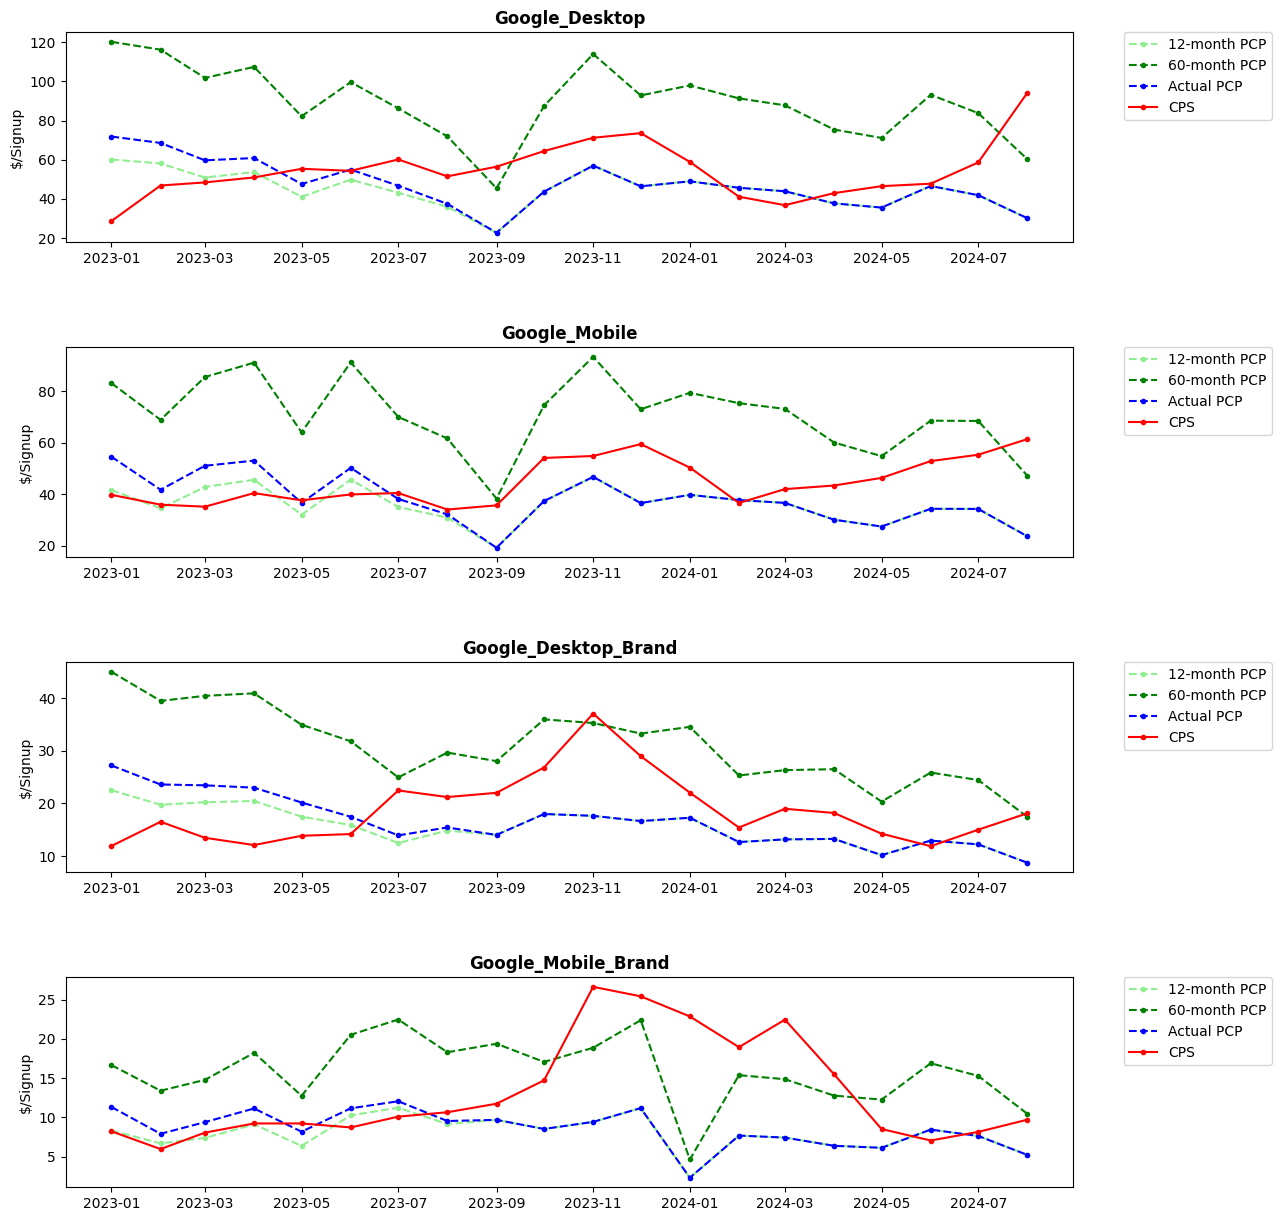

In [51]:
google_plot(summary_all[summary_all.signup_month >= '2023-01-01'])

### (4) 2024 H1 Report

In [54]:
summary_all_H1.head()

,channels,signup_month,signups,12_mo_pcp,12_mo_pcp_per_signup,60_mo_pcp_per_signup,realized_pcp,channel,date,spend_actuals,signups_cps,realized_pcp_per_signup,cps
0,Google_Desktop,2024-01-01,9335,456952.607122,48.950467,97.900934,456952.607122,Google_Desktop,2024-01-01,547712.18,9302.0,48.950467,58.881120
1,Google_Desktop,2024-02-01,9193,419647.624519,45.648605,91.297210,419647.624519,Google_Desktop,2024-02-01,377011.61,9174.0,45.648605,41.095663
2,Google_Desktop,2024-03-01,9354,410464.596429,43.881184,87.762368,410464.596429,Google_Desktop,2024-03-01,340917.27,9270.0,43.881184,36.776405
3,Google_Desktop,2024-04-01,8373,315680.670420,37.702218,75.404436,315680.670420,Google_Desktop,2024-04-01,331721.35,7727.0,37.702218,42.930160
4,Google_Desktop,2024-05-01,9188,326582.574940,35.544468,71.088937,326582.574940,Google_Desktop,2024-05-01,424720.67,9138.0,35.544468,46.478515


Why do we have significant differences in May/August for signup numbers between cps and what you're pulling? These should be coming from the same data source

In [68]:
summary_all.loc[summary_all.signup_month >= '2024-01-01', ['channels', 'signup_month', 'signups', 'signups_cps']].assign(difference = lambda x : (x.signups - x.signups_cps)/x.signups_cps).sort_values(by='signup_month').style.background_gradient(cmap='Reds', subset=['difference']).format({'signups_cps': '{:,.0f}', 'signups': '{:,.0f}', 'difference': '{:.2%}'})

,channels,signup_month,signups,signups_cps,difference
96,Google_Desktop,2024-01-01 00:00:00,"9,335","9,302",0.35%
399,Google_Mobile_Brand,2024-01-01 00:00:00,"18,560","18,590",-0.16%
199,Google_Desktop_Brand,2024-01-01 00:00:00,"10,508","10,541",-0.31%
301,Google_Mobile,2024-01-01 00:00:00,"29,881","29,839",0.14%
97,Google_Desktop,2024-02-01 00:00:00,"9,193","9,174",0.21%
400,Google_Mobile_Brand,2024-02-01 00:00:00,"22,045","22,086",-0.19%
302,Google_Mobile,2024-02-01 00:00:00,"29,130","29,081",0.17%
200,Google_Desktop_Brand,2024-02-01 00:00:00,"11,687","11,743",-0.48%
98,Google_Desktop,2024-03-01 00:00:00,"9,354","9,270",0.91%
303,Google_Mobile,2024-03-01 00:00:00,"35,257","35,085",0.49%


In [71]:
summary_all.columns

Index(['channels', 'signup_month', 'signups', '12_mo_pcp',
       '12_mo_pcp_per_signup', '60_mo_pcp_per_signup', 'realized_pcp',
       'channel', 'date', 'spend_actuals', 'signups_cps',
       'realized_pcp_per_signup', 'cps'],
      dtype='object')

In [72]:
# 2024 H1 
summary_all_H1 = summary_all.loc[(summary_all.signup_month >= '2024-01-01') & (summary_all.signup_month < '2024-07-01')].reset_index(drop=True)
summary_all_H1['60_mo_pcp'] = summary_all_H1['12_mo_pcp']*2
summary_all_H1['spend'] = summary_all_H1['cps'] * summary_all_H1['signups_cps']
h1_report = summary_all_H1.groupby(['channels'], as_index=False)[['12_mo_pcp', '60_mo_pcp', 'spend', 'signups', 'realized_pcp']].sum()
h1_report['cps'] = h1_report['spend']/h1_report['signups']
h1_report['12_mo_pcp_per_signup'] = h1_report['12_mo_pcp']/h1_report['signups']
h1_report['60_mo_pcp_per_signup'] = h1_report['60_mo_pcp']/h1_report['signups']
h1_report['realized_pcp_per_signup'] = h1_report['realized_pcp']/h1_report['signups']

In [77]:
h1_report[['channels', 'cps', 'realized_pcp_per_signup', '12_mo_pcp_per_signup', '60_mo_pcp_per_signup']].style.background_gradient('Greens', subset=['realized_pcp_per_signup', '12_mo_pcp_per_signup', '60_mo_pcp_per_signup']).format({'cps': '${:,.2f}', 'realized_pcp_per_signup': '${:,.2f}', '12_mo_pcp_per_signup': '${:,.2f}', '60_mo_pcp_per_signup': '${:,.2f}'}).background_gradient(cmap='Reds', subset=['cps'])

,channels,cps,realized_pcp_per_signup,12_mo_pcp_per_signup,60_mo_pcp_per_signup
0,Google_Desktop,$44.89,$43.30,$43.30,$86.59
1,Google_Desktop_Brand,$16.29,$13.10,$13.10,$26.20
2,Google_Mobile,$44.92,$34.15,$34.15,$68.29
3,Google_Mobile_Brand,$15.49,$6.55,$6.55,$13.11
